- Input: 2022([NOAA data](https://www.ncei.noaa.gov/data/global-hourly/archive/csv/))
- Output: StationReference.csv     where station latlon, country, etc. are stroed

# Create Station reference dataframe
Given a folder containing multiple .csv files, Iterate through all .csv, get data and store them in a new dataframe as reference.

In [2]:
import glob
import pandas as pd

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pyproj
from mpl_toolkits.basemap import Basemap

In [2]:
def find_between( s, first, last ):
    try:
        start = s.index( first ) + len( first )+10
        end = s.index( last, start )
        return s[start:end]
    except ValueError:
        return ""

In [3]:
# https://stackoverflow.com/questions/14262405/loop-through-all-csv-files-in-a-folder
columns = ['STATION','LATITUDE','LONGITUDE','ELEVATION','NAME']
StationReference = pd.DataFrame(columns=columns)
path = '../Data/2022/*.csv'
for fname in glob.glob(path):
    temp = pd.read_csv(fname)
    temp_data = temp[columns].iloc[0:1,:] # Get first row of data
    temp_data['filename'] = find_between(fname, '/','.')
    StationReference = pd.concat([StationReference, temp_data], ignore_index=True)

/opt/anaconda3/envs/aviation/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (17,18,47,48,49,50,51,52,53,54) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/envs/aviation/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (57) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/envs/aviation/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (58) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/envs/aviation/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (17,18,43,44,45,46,47,48,49,50) have mixed types.Specify dtype option on import or set low_memory=False.
  exec

In [4]:
StationReference

,STATION,LATITUDE,LONGITUDE,ELEVATION,NAME,filename
0,57328099999,31.200000,107.500000,344.0,"DA XIAN, CH",57328099999
1,71393099999,51.100000,-114.000000,1081.0,"CALGARY INTERNATIONAL CS, CA",71393099999
2,72210103039,37.450000,-106.800000,3593.9,"WOLF CREEK PASS, CO US",72210103039
3,71670099999,46.770000,-65.000000,34.0,"KOUCHIBOUGUAC CS, CA",71670099999
4,40632099999,34.883333,44.650000,220.0,"TUZ, IZ",40632099999
...,...,...,...,...,...,...
12976,40675099999,31.717000,46.100000,6.0,"RAFAEI, IZ",40675099999
12977,42393099999,26.133333,86.583333,50.0,"SUPAUL, IN",42393099999
12978,59658099999,21.216667,110.400000,28.0,"ZHANJIANG, CH",59658099999
12979,71637099999,53.416667,-111.733333,687.0,"RANFURLY AUTO, CA",71637099999


In [3]:
#StationReference.to_csv('../Data/StationReference.csv', index=False)
StationReference = pd.read_csv('../Data/StationReference.csv')

# Reverse Geocoder
find stations within US precisely

https://github.com/thampiman/reverse-geocoder

In [6]:
StationReference['latlon'] = StationReference[['LATITUDE','LONGITUDE']].apply(tuple, axis=1)
StationReference

,STATION,LATITUDE,LONGITUDE,ELEVATION,NAME,filename,latlon
0,57328099999,31.200000,107.500000,344.0,"DA XIAN, CH",57328099999,"(31.2, 107.5)"
1,71393099999,51.100000,-114.000000,1081.0,"CALGARY INTERNATIONAL CS, CA",71393099999,"(51.1, -114.0)"
2,72210103039,37.450000,-106.800000,3593.9,"WOLF CREEK PASS, CO US",72210103039,"(37.45, -106.8)"
3,71670099999,46.770000,-65.000000,34.0,"KOUCHIBOUGUAC CS, CA",71670099999,"(46.77, -65.0)"
4,40632099999,34.883333,44.650000,220.0,"TUZ, IZ",40632099999,"(34.8833333, 44.65)"
...,...,...,...,...,...,...,...
12976,40675099999,31.717000,46.100000,6.0,"RAFAEI, IZ",40675099999,"(31.717, 46.1)"
12977,42393099999,26.133333,86.583333,50.0,"SUPAUL, IN",42393099999,"(26.1333333, 86.5833333)"
12978,59658099999,21.216667,110.400000,28.0,"ZHANJIANG, CH",59658099999,"(21.2166667, 110.4)"
12979,71637099999,53.416667,-111.733333,687.0,"RANFURLY AUTO, CA",71637099999,"(53.4166666, -111.7333333)"


In [7]:
import reverse_geocoder as rg
coordinates = StationReference['latlon'].values.tolist()
coordinates
results = rg.search(coordinates) # default mode = 2

Loading formatted geocoded file...


In [8]:
StationReference['name'] = None
StationReference['admin1'] = None
StationReference['admin2'] = None
StationReference['cc'] = None

for r in range(len(results)):
    result = results[r]
    
    StationReference.loc[r,'name'] = result['name']
    StationReference.loc[r,'admin1'] = result['admin1']
    StationReference.loc[r,'admin2'] = result['admin2']
    StationReference.loc[r,'cc'] = result['cc']

In [10]:
#StationReference.to_csv('../Data/StationReference.csv', index=False)

# Visualize on a Map

In [4]:
StationReference = pd.read_csv('../Data/StationReference.csv')
StationReference.head(5)

,STATION,LATITUDE,LONGITUDE,ELEVATION,NAME,filename,latlon,name,admin1,admin2,cc
0,57328099999,31.200000,107.50,344.0,"DA XIAN, CH",57328099999,"(31.2, 107.5)",Nanwai,Sichuan,NaN,CN
1,71393099999,51.100000,-114.00,1081.0,"CALGARY INTERNATIONAL CS, CA",71393099999,"(51.1, -114.0)",Calgary,Alberta,NaN,CA
2,72210103039,37.450000,-106.80,3593.9,"WOLF CREEK PASS, CO US",72210103039,"(37.45, -106.8)",Pagosa Springs,Colorado,Archuleta County,US
3,71670099999,46.770000,-65.00,34.0,"KOUCHIBOUGUAC CS, CA",71670099999,"(46.77, -65.0)",Richibucto,New Brunswick,NaN,CA
4,40632099999,34.883333,44.65,220.0,"TUZ, IZ",40632099999,"(34.8833333, 44.65)",Tozkhurmato,Salah ad Din Governorate,NaN,IQ


In [12]:
df = StationReference[StationReference['cc'] == 'US']

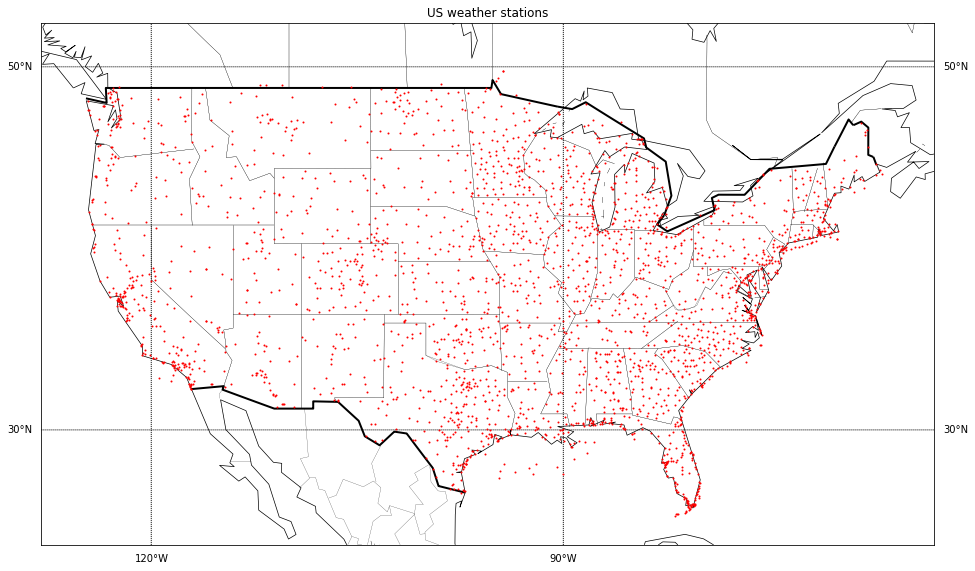

In [13]:
# Plot basemap
fig = plt.figure(figsize=(16,12))
m = Basemap(llcrnrlon = -128, llcrnrlat = 22.5, urcrnrlon = -63, urcrnrlat = 52, projection='merc')
m.drawcoastlines(linewidth=0.7)
m.drawcountries(linewidth=2)
m.drawstates(linewidth=0.2)
# draw parallels
m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1])
# draw meridians
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])

lat = df['LATITUDE']
lon = df['LONGITUDE']
xpt, ypt = m(list(lon), list(lat))
m.plot(xpt,ypt,'ro', markersize=1)  

plt.title("US weather stations")
plt.savefig('../Output/US_stations.png')

In [14]:
df = StationReference

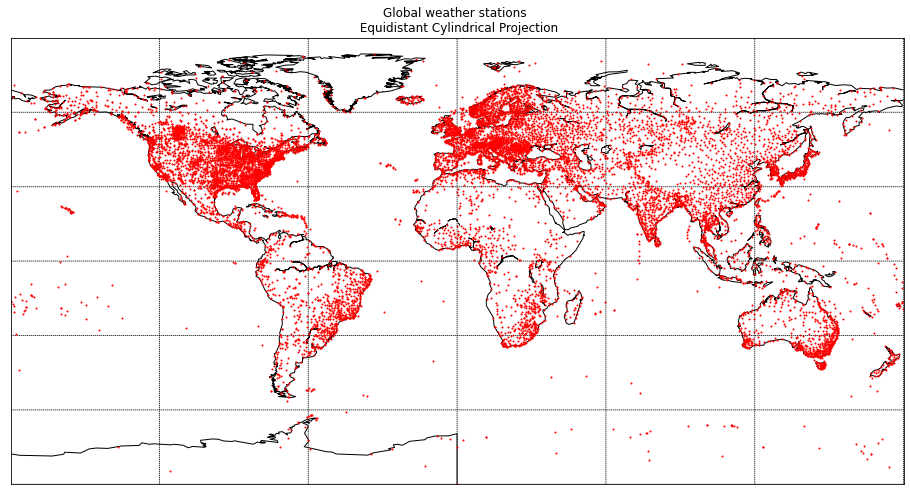

In [15]:
fig = plt.figure(figsize=(16,12))

m = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=-180,urcrnrlon=180,resolution='c')
m.drawcoastlines()
#m.fillcontinents(color='coral',lake_color='aqua')
# draw parallels and meridians.
m.drawparallels(np.arange(-90.,91.,30.))
m.drawmeridians(np.arange(-180.,181.,60.))
#m.drawmapboundary(fill_color='aqua')


lat = df['LATITUDE']
lon = df['LONGITUDE']
xpt, ypt = m(list(lon), list(lat))
m.plot(xpt,ypt,'ro', markersize=1)

plt.title("Global weather stations \n Equidistant Cylindrical Projection")
plt.savefig('../Output/Global_stations.png')
plt.show()

# US stations

In [5]:
print("Number of weather stations in US:", len(StationReference[StationReference['cc'] == 'US']))
print("Number of weather stations in California:", len(StationReference[StationReference['admin1'] == 'California']))
print("Number of weather stations in Texas:", len(StationReference[StationReference['admin1'] == 'Texas']))

Number of weather stations in US: 2824
Number of weather stations in California: 173
Number of weather stations in Texas: 217


# SFO station

In [19]:
StationReference[StationReference['name'] == 'San Francisco']

,STATION,LATITUDE,LONGITUDE,ELEVATION,NAME,filename,latlon,name,admin1,admin2,cc
2115,99847999999,37.7980,-122.3930,10.0,"SAN FRANCISCO PIER 1, CA US",99847999999,"(37.798, -122.393)",San Francisco,California,San Francisco County,US
5736,99401699999,37.8070,-122.4650,2.0,"SAN FRANCISCO, CA US",99401699999,"(37.807, -122.465)",San Francisco,California,San Francisco County,US
12710,99999923272,37.7705,-122.4269,45.7,"SAN FRANCISCO DOWNTOWN, CA US",99999923272,"(37.7705, -122.4269)",San Francisco,California,San Francisco County,US
